In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_poisson_deviance
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import RandomizedSearchCV


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [4]:
base = pd.read_csv('input_data_w_formatted.csv')
base.shape

(230469, 17)

In [5]:
base.head()

,year,insured_years,radius,prior_loss_frequency,certificate_age_years,driver_gender,driver_age,MVR_violation_points,claim_counts,claim_frequency,garaging_area_map,vehicle_type_map,commodity_gravel,commodity_hazardous,commodity_liquids - fuel,commodity_metal,prior_insurance_limit_scaled
0,2020,0.916667,1000,0.167221,0.5,1,50,4,0,0.0,3,2,0,0,0,1,5.0
1,2020,0.916667,400,0.071928,4.0,1,20,4,0,0.0,1,1,0,0,0,0,10.0
2,2020,0.916667,250,0.150915,8.0,0,30,4,0,0.0,2,3,0,0,0,1,2.5
3,2019,0.666667,400,0.187592,1.0,0,50,8,1,1.5,2,1,0,0,0,1,20.0
4,2019,0.666667,1000,0.075468,4.0,1,30,8,1,1.5,3,3,0,0,0,0,10.0


In [6]:
## Univariate Analysis:

target_cols = ['claim_counts','claim_frequency','insured_years']
features = [x for x in base.columns if x not in target_cols]

def generate_univariate_report(df):
    """
    Generates a univariate analysis report for all features in a DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.

    Returns:
        pd.DataFrame: A DataFrame containing the univariate report.
    """
    report_list = []
    total_rows = len(df)

    for col in df.columns:
        # Check if the column data type is numeric
        is_numeric = pd.api.types.is_numeric_dtype(df[col])

        # Initialize dictionary with common stats
        stats = {
            'Feature Name': col,
            'Row Count': total_rows,
            'Non-Null Count': df[col].count(),
            'Unique Values': df[col].nunique(),
            'Min': np.nan, 
            'Max': np.nan, 
            'Mean': np.nan,
            'Std Dev': np.nan,
            '25% Quantile': np.nan,
            '50% Quantile (Median)': np.nan,
            '75% Quantile': np.nan,
        }

        # Calculate numeric-only stats if the column is numeric
        if is_numeric:
            stats['Min'] = df[col].min() 
            stats['Max'] = df[col].max() 
            stats['Mean'] = df[col].mean()
            stats['Std Dev'] = df[col].std()
            stats['25% Quantile'] = df[col].quantile(0.25)
            stats['50% Quantile (Median)'] = df[col].quantile(0.50)
            stats['75% Quantile'] = df[col].quantile(0.75)

        report_list.append(stats)

    # Convert the list of dictionaries to a DataFrame
    univariate_df = pd.DataFrame(report_list)
    return univariate_df

# 2. Generate the report by calling the function
univariate_report = generate_univariate_report(base[features])

# 3. Print the resulting report
print("Univariate Analysis Report:")
univariate_report

Univariate Analysis Report:


,Feature Name,Row Count,Non-Null Count,Unique Values,Min,Max,Mean,Std Dev,25% Quantile,50% Quantile (Median),75% Quantile
0,year,230469,230469,2,2019.000000,2020.000000,2019.500505,0.500001,2019.000000,2020.000000,2020.000000
1,radius,230469,230469,5,50.000000,1000.000000,545.521740,385.556729,250.000000,400.000000,1000.000000
2,prior_loss_frequency,230469,230469,230300,-0.088996,0.355675,0.120037,0.050055,0.086128,0.120109,0.153682
3,certificate_age_years,230469,230469,5,0.500000,8.000000,4.197460,3.243740,1.000000,2.000000,8.000000
4,driver_gender,230469,230469,2,0.000000,1.000000,0.599616,0.489977,0.000000,1.000000,1.000000
5,driver_age,230469,230469,5,20.000000,60.000000,43.000924,11.015505,40.000000,40.000000,50.000000
6,MVR_violation_points,230469,230469,3,0.000000,8.000000,3.903397,3.086745,0.000000,4.000000,8.000000
7,garaging_area_map,230469,230469,3,1.000000,3.000000,1.998768,0.774084,1.000000,2.000000,3.000000
8,vehicle_type_map,230469,230469,3,1.000000,3.000000,2.002525,0.837077,1.000000,2.000000,3.000000
9,commodity_gravel,230469,230469,2,0.000000,1.000000,0.050167,0.218290,0.000000,0.000000,0.000000


In [7]:
## Bivariate Analysis:

def mean_of_positive(x):
    """Calculates the median of only the positive values in a series."""
    positive_values = x[x > 0]
    return positive_values.mean()

def create_bivariate_report(df, features, targets=['claim_counts', 'claim_frequency']):
    """
    Generates a single, consolidated bivariate report DataFrame with total claim counts
    and a conditional median for claims > 0.
    """
    all_reports_list = []

    for feature in features:
        if feature in targets:
            continue

        temp_df = df.copy()
        grouping_col = feature

        # Bin feature if it has more than 10 unique values
        if temp_df[feature].nunique() > 10:
            try:
                temp_df[f'{feature}_bin'] = pd.cut(temp_df[feature], bins=5)
                grouping_col = f'{feature}_bin'
            except TypeError:
                print(f"Warning: Feature '{feature}' is non-numeric with >10 unique values. Grouping by original values.")
                pass

        # Define aggregations including sum and the custom median function
        aggregations = {
            'claim_counts': ['mean', 'sum', mean_of_positive],
            'claim_frequency': ['mean']
        }
        
        # Group by the feature or its bins and calculate aggregates
        report = temp_df.groupby(grouping_col).agg(aggregations)

        # Flatten the multi-level column index
        report.columns = ['_'.join(map(str, col)).strip() for col in report.columns.values]
        
        # Rename the new custom columns for clarity
        report = report.rename(columns={
            'claim_counts_sum': 'num_claim_counts',
            f'claim_counts_{mean_of_positive.__name__}': 'claim_counts_positive_mean'
        })
        
        report = report.reset_index()
        report['feature_name'] = feature
        report = report.rename(columns={grouping_col: 'feature_bin'})
        report['feature_bin'] = report['feature_bin'].astype(str)

        all_reports_list.append(report)

    # Concatenate all the individual DataFrames into the final report
    final_report = pd.concat(all_reports_list, ignore_index=True)

    # Reorder columns to the desired format, including the new ones
    final_report = final_report[[
        'feature_name',
        'feature_bin',
        'num_claim_counts',
        'claim_counts_mean',
        'claim_counts_positive_mean',
        'claim_frequency_mean',
    ]]

    return final_report

# 3. Generate the final, enhanced report
bivariate_report = create_bivariate_report(base, features)

# 4. Print the final DataFrame
print("Consolidated Bivariate Report:")
bivariate_report

Consolidated Bivariate Report:


,feature_name,feature_bin,num_claim_counts,claim_counts_mean,claim_counts_positive_mean,claim_frequency_mean
0,year,2019,16496,0.143296,1.117539,0.190707
1,year,2020,16539,0.143380,1.119846,0.190780
2,radius,50,1475,0.064458,1.044618,0.086522
3,radius,100,2083,0.090025,1.063841,0.119458
4,radius,250,4930,0.107450,1.076184,0.143331
5,radius,400,7440,0.160757,1.123528,0.212840
6,radius,1000,17107,0.185371,1.143745,0.246950
7,prior_loss_frequency,"(-0.0894, -6.2e-05]",192,0.104632,1.090909,0.138748
8,prior_loss_frequency,"(-6.2e-05, 0.0889]",7649,0.127762,1.106946,0.169597
9,prior_loss_frequency,"(0.0889, 0.178]",20427,0.145813,1.118675,0.194294


In [8]:
## Baseline Model:

# Define variables for the model
y = base['claim_counts']
X = base[features]
X = sm.add_constant(X) # Add an intercept

# --- Option 1: Using 'exposure' (Recommended) ---
exposure = base['insured_years']
model_exposure = sm.Poisson(y, X, exposure=exposure).fit()

# --- Option 2: Using 'offset' ---
offset = np.log(base['insured_years'])
model_offset = sm.Poisson(y, X, offset=offset).fit()


print("--- MODEL RESULTS USING 'exposure' ---")
print(model_exposure.summary())

print("\n\n--- MODEL RESULTS USING 'offset' ---")
print(model_offset.summary())

Optimization terminated successfully.
         Current function value: 0.402518
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.402518
         Iterations 10
--- MODEL RESULTS USING 'exposure' ---
                          Poisson Regression Results                          
Dep. Variable:           claim_counts   No. Observations:               230469
Model:                        Poisson   Df Residuals:                   230454
Method:                           MLE   Df Model:                           14
Date:                Wed, 22 Oct 2025   Pseudo R-squ.:                 0.06351
Time:                        11:30:30   Log-Likelihood:                -92768.
converged:                       True   LL-Null:                       -99060.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------

In [9]:
## Poisson Reqression:

# --- 1. Data Preparation ---
# Assuming 'base' DataFrame and 'features' list are defined
X = base[features]
y = base['claim_counts']
exposure = base['insured_years']

# Add constant term
X = sm.add_constant(X)

# Train-test split
X_train, X_test, y_train, y_test, exposure_train, exposure_test = train_test_split(
    X, y, exposure, test_size=0.2, random_state=42
)

# --- 2. Fit Poisson GLM ---
print("--- Fitting Poisson Model ---")
poisson_model = sm.GLM(
    y_train,
    X_train,
    family=sm.families.Poisson(),
    exposure=exposure_train 
)
poisson_results = poisson_model.fit()
print(poisson_results.summary())

# --- 3. Overdispersion Check ---
print("\n--- Overdispersion Check ---")
mu = poisson_results.fittedvalues
pearson_resid = (y_train - mu) / np.sqrt(mu)
df = poisson_results.df_resid
chi2 = np.sum(pearson_resid**2)
dispersion_parameter = chi2 / df

print(f"Pearson Chi-Squared Statistic: {chi2:.2f}")
print(f"Degrees of Freedom: {df:.2f}")
print(f"Dispersion Parameter (φ): {dispersion_parameter:.2f}")

if dispersion_parameter > 1.5:
    print("\nResult: Strong evidence of overdispersion (φ >> 1).")
    print("A Negative Binomial model is recommended. ✅")
elif dispersion_parameter > 1:
    print("\nResult: Evidence of overdispersion (φ > 1).")
    print("A Negative Binomial model is likely a better fit.")
else:
    print("\nResult: No evidence of overdispersion (φ ≈ 1).")
    print("The Poisson model is likely a good fit.")

# --- 4. Predictions & Evaluation ---
predictions = poisson_results.predict(X_test, exposure=exposure_test)

rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
poisson_dev = mean_poisson_deviance(y_test, predictions)

print("\n--- Model Performance on Test Data ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Poisson Deviance: {poisson_dev:.4f}")


--- Fitting Poisson Model ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:           claim_counts   No. Observations:               184375
Model:                            GLM   Df Residuals:                   184360
Model Family:                 Poisson   Df Model:                           14
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -74193.
Date:                Wed, 22 Oct 2025   Deviance:                       99471.
Time:                        11:30:32   Pearson chi2:                 1.83e+05
No. Iterations:                     6   Pseudo R-squ. (CS):            0.05315
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [10]:
## comparison with baseline y_bar (mean):
# --- 5. Baseline Model Comparison ---
print("\n--- Baseline Model (y = mean of training set) ---")

# Baseline prediction: constant mean of training y
y_baseline = np.full_like(y_test, y_train.mean(), dtype=float)

# Baseline metrics
rmse_base = np.sqrt(mean_squared_error(y_test, y_baseline))
mae_base = mean_absolute_error(y_test, y_baseline)
poisson_dev_base = mean_poisson_deviance(y_test, y_baseline)

print(f"Baseline RMSE: {rmse_base:.4f}")
print(f"Baseline MAE: {mae_base:.4f}")
print(f"Baseline Poisson Deviance: {poisson_dev_base:.4f}")

# --- Relative Improvement (% decrease from baseline) ---
def rel_improvement(base, model):
    return ((base - model) / base) * 100

print("\n--- Relative Improvement vs Baseline ---")
print(f"RMSE Improvement: {rel_improvement(rmse_base, rmse):.2f}%")
print(f"MAE Improvement: {rel_improvement(mae_base, mae):.2f}%")
print(f"Poisson Deviance Improvement: {rel_improvement(poisson_dev_base, poisson_dev):.2f}%")



--- Baseline Model (y = mean of training set) ---
Baseline RMSE: 0.3965
Baseline MAE: 0.2501
Baseline Poisson Deviance: 0.6019

--- Relative Improvement vs Baseline ---
RMSE Improvement: 2.87%
MAE Improvement: 6.07%
Poisson Deviance Improvement: 10.13%


In [11]:
## removing not important features:

# --- 1. Data Preparation ---
# Assuming 'base' DataFrame and 'features' list are defined
features_to_use = [x for x in features if x not in ['commodity_hazardous','driver_gender','year','commodity_liquids - fuel','prior_insurance_limit_scaled']]
X = base[features_to_use]
y = base['claim_counts']
exposure = base['insured_years']

# Add constant term
X = sm.add_constant(X)

# Train-test split
X_train, X_test, y_train, y_test, exposure_train, exposure_test = train_test_split(
    X, y, exposure, test_size=0.2, random_state=42
)

# --- 2. Fit Poisson GLM ---
print("--- Fitting Poisson Model ---")
poisson_model = sm.GLM(
    y_train,
    X_train,
    family=sm.families.Poisson(),
    exposure=exposure_train  
)
poisson_results = poisson_model.fit()
print(poisson_results.summary())

# --- 3. Overdispersion Check ---
print("\n--- Overdispersion Check ---")
mu = poisson_results.fittedvalues
pearson_resid = (y_train - mu) / np.sqrt(mu)
df = poisson_results.df_resid
chi2 = np.sum(pearson_resid**2)
dispersion_parameter = chi2 / df

print(f"Pearson Chi-Squared Statistic: {chi2:.2f}")
print(f"Degrees of Freedom: {df:.2f}")
print(f"Dispersion Parameter (φ): {dispersion_parameter:.2f}")

if dispersion_parameter > 1.5:
    print("\nResult: Strong evidence of overdispersion (φ >> 1).")
    print("A Negative Binomial model is recommended. ✅")
elif dispersion_parameter > 1:
    print("\nResult: Evidence of overdispersion (φ > 1).")
    print("A Negative Binomial model is likely a better fit.")
else:
    print("\nResult: No evidence of overdispersion (φ ≈ 1).")
    print("The Poisson model is likely a good fit.")

# --- 4. Predictions & Evaluation ---
predictions = poisson_results.predict(X_test, exposure=exposure_test)

rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
poisson_dev = mean_poisson_deviance(y_test, predictions)

print("\n--- Model Performance on Test Data ---")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Poisson Deviance: {poisson_dev:.4f}")


--- Fitting Poisson Model ---
                 Generalized Linear Model Regression Results                  
Dep. Variable:           claim_counts   No. Observations:               184375
Model:                            GLM   Df Residuals:                   184365
Model Family:                 Poisson   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -74193.
Date:                Wed, 22 Oct 2025   Deviance:                       99472.
Time:                        11:30:33   Pearson chi2:                 1.83e+05
No. Iterations:                     6   Pseudo R-squ. (CS):            0.05315
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------


In [12]:
# --- 5. Baseline Model Comparison ---
print("\n--- Baseline Model (y = mean of training set) ---")

# Baseline prediction: constant mean of training y
y_baseline = np.full_like(y_test, y_train.mean(), dtype=float)

# Baseline metrics
rmse_base = np.sqrt(mean_squared_error(y_test, y_baseline))
mae_base = mean_absolute_error(y_test, y_baseline)
poisson_dev_base = mean_poisson_deviance(y_test, y_baseline)

print(f"Baseline RMSE: {rmse_base:.4f}")
print(f"Baseline MAE: {mae_base:.4f}")
print(f"Baseline Poisson Deviance: {poisson_dev_base:.4f}")

# --- Relative Improvement (% decrease from baseline) ---
def rel_improvement(base, model):
    return ((base - model) / base) * 100

print("\n--- Relative Improvement vs Baseline ---")
print(f"RMSE Improvement: {rel_improvement(rmse_base, rmse):.2f}%")
print(f"MAE Improvement: {rel_improvement(mae_base, mae):.2f}%")
print(f"Poisson Deviance Improvement: {rel_improvement(poisson_dev_base, poisson_dev):.2f}%")



--- Baseline Model (y = mean of training set) ---
Baseline RMSE: 0.3965
Baseline MAE: 0.2501
Baseline Poisson Deviance: 0.6019

--- Relative Improvement vs Baseline ---
RMSE Improvement: 2.87%
MAE Improvement: 6.07%
Poisson Deviance Improvement: 10.12%


In [13]:
## ADDING FEATURES:

In [22]:
base['High_Limit_Policy'] = (base['prior_insurance_limit_scaled'] >= 20).astype(int)
base['High_Limit_Policy'].value_counts()

High_Limit_Policy
0    172735
1     57734
Name: count, dtype: int64

In [23]:
base['Hazardous_Long_Haul'] = base.commodity_hazardous * base.radius

base['driver_risk_score'] = (
    (60 - base['driver_age']) / 10 + base['MVR_violation_points'] / 2 +
    base['driver_gender'] * 0.5
)

base['log_radius'] = np.log1p(base['radius'])

base['prior_loss_x_mvr'] = base['prior_loss_frequency'] * base['MVR_violation_points']

base['heavy_vehicle_risk'] = (
    base['vehicle_type_map'].replace({1:0.5, 2:1, 3:1.5}) *
    (base['commodity_hazardous'] + base['commodity_liquids - fuel'])
)

base['urban_density_index'] = base.garaging_area_map * base.radius

base['experience_factor'] = base['certificate_age_years'] / (1 + base['prior_loss_frequency'])

base['limit_x_radius'] = base.prior_insurance_limit_scaled * base.radius

base['mvr_per_age'] = base['MVR_violation_points'] / base['driver_age']

In [24]:
## Bivariate Report:

feature_list = [feat for feat in base.columns if feat not in ['radius','claim_frequency','claim_counts', 'insured_years']]
bivariate_report = create_bivariate_report(base, feature_list)
print("Consolidated Bivariate Report:")
bivariate_report

KeyError: "Column(s) ['claim_frequency'] do not exist"

In [ ]:
base.drop('claim_frequency', axis=1, inplace=True)


--- Top 10 Features Most Correlated with Claim Frequency ---
                 feature  corr_with_claim_freq
9       vehicle_type_map              0.177633
21   urban_density_index              0.106679
18            log_radius              0.106087
2                 radius              0.100595
23        limit_x_radius              0.061485
24           mvr_per_age              0.056151
19      prior_loss_x_mvr              0.045485
17     driver_risk_score              0.044058
8      garaging_area_map              0.043136
7   MVR_violation_points              0.037261

--- Variance Inflation Factors (VIF) ---
                         Feature           VIF
5                     driver_age  8.929878e+06
16             driver_risk_score  8.846845e+06
6           MVR_violation_points  2.805844e+06
4                  driver_gender  6.794153e+04
21             experience_factor  4.943109e+02
3          certificate_age_years  4.926564e+02
1                         radius  1.637150e+01
23 

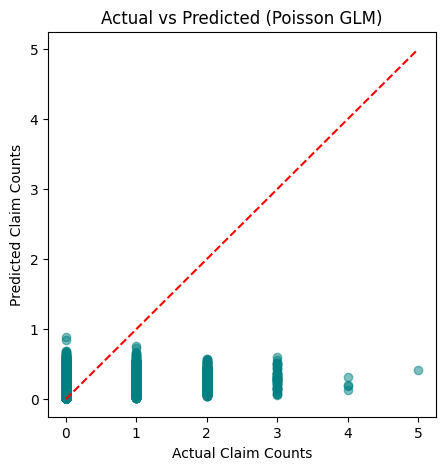

In [18]:
## Doing Feature Selection:

# -------------------------------
# Step 1. Prepare target & exposure
# -------------------------------
y = base['claim_counts']
exposure = base['insured_years']
y_freq = y / exposure   # Claim frequency target

# Exclude target & exposure columns from features
exclude_cols = ['claim_counts', 'insured_years']
feature_cols = [c for c in base.columns if c not in exclude_cols]

X = base[feature_cols].copy()
X = sm.add_constant(X, has_constant='add')

# -------------------------------
# Step 2. Correlation Check
# -------------------------------
corrs = pd.DataFrame({
    'feature': X.columns,
    'corr_with_claim_freq': [np.corrcoef(X[c], y_freq)[0,1] if X[c].nunique() > 1 else 0 for c in X.columns]
}).sort_values('corr_with_claim_freq', ascending=False)

print("\n--- Top 10 Features Most Correlated with Claim Frequency ---")
print(corrs.head(10))

# -------------------------------
# Step 3. Multicollinearity Check (VIF)
# -------------------------------
# Drop constant for VIF computation
X_vif = X.drop(columns=['const'])
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print("\n--- Variance Inflation Factors (VIF) ---")
print(vif_data.sort_values('VIF', ascending=False))

# Drop features with very high VIF (>10)
high_vif_features = vif_data.loc[vif_data['VIF'] > 10, 'Feature'].tolist()
X_reduced = X.drop(columns=high_vif_features, errors='ignore')

print(f"\nDropped {len(high_vif_features)} high-VIF features: {high_vif_features}")

# -------------------------------
# Step 4. Stepwise AIC/BIC Selection (Forward)
# -------------------------------
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out=0.05, 
                       verbose=True):
    """Forward-backward feature selection using p-values from statsmodels"""
    included = list(initial_list)
    while True:
        changed = False
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        for new_col in excluded:
            model = sm.GLM(y, sm.add_constant(X[included + [new_col]]), 
                           family=sm.families.Poisson(), 
                           exposure=exposure).fit()
            new_pval[new_col] = model.pvalues[new_col]
        best_pval = new_pval.min() if not new_pval.empty else None
        if best_pval is not None and best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print(f"Add {best_feature:30} with p-value {best_pval:.6f}")

        model = sm.GLM(y, sm.add_constant(X[included]), 
                       family=sm.families.Poisson(), 
                       exposure=exposure).fit()
        pvalues = model.pvalues.iloc[1:]  # exclude intercept
        worst_pval = pvalues.max()
        if worst_pval is not None and worst_pval > threshold_out:
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            changed = True
            if verbose:
                print(f"Drop {worst_feature:30} with p-value {worst_pval:.6f}")

        if not changed:
            break
    return included

print("\n--- Stepwise Feature Selection (AIC-driven) ---")
selected_features = stepwise_selection(X_reduced.drop(columns=['const'], errors='ignore'), y)
print(f"\nFinal Selected Features ({len(selected_features)}):")
print(selected_features)

# -------------------------------
# Step 6. Final Poisson Model Using Selected Features
# -------------------------------
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_poisson_deviance
from sklearn.model_selection import train_test_split

# Prepare data
X_final = X_reduced[selected_features]
y_final = y
exposure_final = exposure

# Train-test split (important for fair evaluation)
X_train, X_test, y_train, y_test, exp_train, exp_test = train_test_split(
    X_final, y_final, exposure_final, test_size=0.2, random_state=42
)

# Fit GLM Poisson with exposure as offset
poisson_model = sm.GLM(
    y_train,
    sm.add_constant(X_train),
    family=sm.families.Poisson(),
    exposure=exp_train
).fit()

# -------------------------------
# Step 7. Model Summary
# -------------------------------
print("\n--- Final Poisson GLM Summary ---")
print(poisson_model.summary())

# -------------------------------
# Step 8. Predictions
# -------------------------------
y_train_pred = poisson_model.predict(sm.add_constant(X_train), exposure=exp_train)
y_test_pred = poisson_model.predict(sm.add_constant(X_test), exposure=exp_test)

# -------------------------------
# Step 9. Baseline Model (predict mean claim count per exposure)
# -------------------------------
y_mean_rate = (y_train / exp_train).mean()
y_baseline = y_mean_rate * exp_test  # expected count = exposure × mean rate

# -------------------------------
# Step 10. Evaluation Metrics
# -------------------------------
def evaluate_model(y_true, y_pred, label):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    poisson_dev = mean_poisson_deviance(y_true, y_pred)
    print(f"\n{label} Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  Mean Poisson Deviance: {poisson_dev:.4f}")
    return rmse, mae, poisson_dev

rmse_model, mae_model, dev_model = evaluate_model(y_test, y_test_pred, "Poisson GLM")
rmse_base, mae_base, dev_base = evaluate_model(y_test, y_baseline, "Baseline (ȳ × exposure)")

# -------------------------------
# Step 11. Relative Improvement
# -------------------------------
def rel_improve(base, model):
    return (base - model) / base * 100

print("\n--- Relative Improvement over Baseline ---")
print(f"RMSE Improvement: {rel_improve(rmse_base, rmse_model):.2f}%")
print(f"MAE Improvement: {rel_improve(mae_base, mae_model):.2f}%")
print(f"Poisson Deviance Improvement: {rel_improve(dev_base, dev_model):.2f}%")

# -------------------------------
# Step 12. Summary Table
# -------------------------------
summary_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'Mean Poisson Deviance'],
    'Baseline': [rmse_base, mae_base, dev_base],
    'Poisson_GLM': [rmse_model, mae_model, dev_model],
    'Improvement (%)': [
        rel_improve(rmse_base, rmse_model),
        rel_improve(mae_base, mae_model),
        rel_improve(dev_base, dev_model)
    ]
})
print("\n--- Performance Comparison ---")
print(summary_df)

# -------------------------------
# Step 13. Plot
# -------------------------------
plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_test_pred, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Claim Counts")
plt.ylabel("Predicted Claim Counts")
plt.title("Actual vs Predicted (Poisson GLM)")
plt.show()


In [19]:
# The Pearson Chi-Squared statistic is a measure of the model's goodness of fit
mu = poisson_model.fittedvalues # Get the predicted mean values
chi2 = np.sum((y - mu)**2 / mu)
# -----------------

df = poisson_model.df_resid
dispersion_parameter = chi2 / df

print(f"Pearson Chi-Squared Statistic: {chi2:.2f}")
print(f"Degrees of Freedom: {df:.2f}")
print(f"Dispersion Parameter (φ): {dispersion_parameter:.2f}")

if dispersion_parameter > 1.5:
    print("\nResult: Strong evidence of overdispersion (φ >> 1).")
    print("A Negative Binomial model is recommended. ✅")
elif dispersion_parameter > 1:
    print("\nResult: Evidence of overdispersion (φ > 1).")
    print("A Negative Binomial model is likely a better fit.")
else:
    print("\nResult: No evidence of overdispersion (φ ≈ 1).")
    print("The Poisson model is likely a good fit.")


Pearson Chi-Squared Statistic: 183116.77
Degrees of Freedom: 184367.00
Dispersion Parameter (φ): 0.99

Result: No evidence of overdispersion (φ ≈ 1).
The Poisson model is likely a good fit.


actual
0    0.134510
1    0.197398
2    0.245542
3    0.294326
4    0.348052
Name: predicted, dtype: float64
actual
0    0.134487
1    0.197205
2    0.246125
3    0.295930
4    0.207575
5    0.418529
Name: predicted, dtype: float64


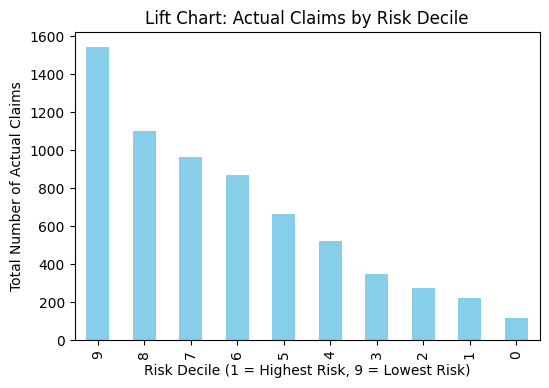

In [20]:
## Average predictions in actual target bins:
tmp = pd.DataFrame({'actual':y_train, 'predicted':y_train_pred})
print(tmp.groupby('actual')['predicted'].mean())

tmp2 = pd.DataFrame({'actual':y_test, 'predicted':y_test_pred})
print(tmp2.groupby('actual')['predicted'].mean())

## Lift Chart:
tmp2['decile'] = pd.qcut(tmp2['predicted'], 10, labels=False, duplicates='drop')

# Calculate the claim rate in each decile
decile_analysis = tmp2.groupby('decile')['actual'].sum().sort_index(ascending=False)

decile_analysis.plot(kind='bar', figsize=(6,4), color='skyblue')
plt.title('Lift Chart: Actual Claims by Risk Decile')
plt.xlabel('Risk Decile (1 = Highest Risk, 9 = Lowest Risk)')
plt.ylabel('Total Number of Actual Claims')
plt.show()


--- Top 10 Features Most Correlated with Claim Frequency ---
                 feature  corr_with_claim_freq
9       vehicle_type_map              0.177633
21   urban_density_index              0.106679
18            log_radius              0.106087
2                 radius              0.100595
23        limit_x_radius              0.061485
24           mvr_per_age              0.056151
19      prior_loss_x_mvr              0.045485
17     driver_risk_score              0.044058
8      garaging_area_map              0.043136
7   MVR_violation_points              0.037261

--- Variance Inflation Factors (VIF) ---
                         Feature           VIF
5                     driver_age  8.929878e+06
16             driver_risk_score  8.846845e+06
6           MVR_violation_points  2.805844e+06
4                  driver_gender  6.794153e+04
21             experience_factor  4.943109e+02
3          certificate_age_years  4.926564e+02
1                         radius  1.637150e+01
23 

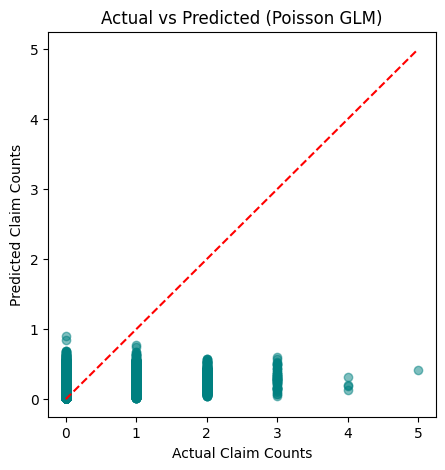

In [21]:
## Negative Binomial:

# -------------------------------
# Step 1. Prepare target & exposure
# -------------------------------
y = base['claim_counts']
exposure = base['insured_years']
y_freq = y / exposure   # Claim frequency target

# Exclude target & exposure columns from features
exclude_cols = ['claim_counts', 'insured_years']
feature_cols = [c for c in base.columns if c not in exclude_cols]

X = base[feature_cols].copy()
X = sm.add_constant(X, has_constant='add')

# -------------------------------
# Step 2. Correlation Check
# -------------------------------
corrs = pd.DataFrame({
    'feature': X.columns,
    'corr_with_claim_freq': [np.corrcoef(X[c], y_freq)[0,1] if X[c].nunique() > 1 else 0 for c in X.columns]
}).sort_values('corr_with_claim_freq', ascending=False)

print("\n--- Top 10 Features Most Correlated with Claim Frequency ---")
print(corrs.head(10))

# -------------------------------
# Step 3. Multicollinearity Check (VIF)
# -------------------------------
# Drop constant for VIF computation
X_vif = X.drop(columns=['const'])
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

print("\n--- Variance Inflation Factors (VIF) ---")
print(vif_data.sort_values('VIF', ascending=False))

# Drop features with very high VIF (>10)
high_vif_features = vif_data.loc[vif_data['VIF'] > 10, 'Feature'].tolist()
X_reduced = X.drop(columns=high_vif_features, errors='ignore')

print(f"\nDropped {len(high_vif_features)} high-VIF features: {high_vif_features}")

# -------------------------------
# Step 4. Stepwise AIC/BIC Selection (Forward)
# -------------------------------
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out=0.05, 
                       verbose=True):
    """Forward-backward feature selection using p-values from statsmodels"""
    included = list(initial_list)
    while True:
        changed = False
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        for new_col in excluded:
            model = sm.GLM(y, sm.add_constant(X[included + [new_col]]), 
                           family=sm.families.NegativeBinomial(), 
                           exposure=exposure).fit()
            new_pval[new_col] = model.pvalues[new_col]
        best_pval = new_pval.min() if not new_pval.empty else None
        if best_pval is not None and best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print(f"Add {best_feature:30} with p-value {best_pval:.6f}")

        model = sm.GLM(y, sm.add_constant(X[included]), 
                       family=sm.families.NegativeBinomial(), 
                       exposure=exposure).fit()
        pvalues = model.pvalues.iloc[1:]  # exclude intercept
        worst_pval = pvalues.max()
        if worst_pval is not None and worst_pval > threshold_out:
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            changed = True
            if verbose:
                print(f"Drop {worst_feature:30} with p-value {worst_pval:.6f}")

        if not changed:
            break
    return included

print("\n--- Stepwise Feature Selection (AIC-driven) ---")
selected_features = stepwise_selection(X_reduced.drop(columns=['const'], errors='ignore'), y)
print(f"\nFinal Selected Features ({len(selected_features)}):")
print(selected_features)

# -------------------------------
# Step 6. Final Poisson Model Using Selected Features
# -------------------------------
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_poisson_deviance
from sklearn.model_selection import train_test_split

# Prepare data
X_final = X_reduced[selected_features]
y_final = y
exposure_final = exposure

# Train-test split (important for fair evaluation)
X_train, X_test, y_train, y_test, exp_train, exp_test = train_test_split(
    X_final, y_final, exposure_final, test_size=0.2, random_state=42
)

# Fit GLM NegativeBinomial with exposure as offset
nb_model = sm.GLM(
    y_train,
    sm.add_constant(X_train),
    family=sm.families.NegativeBinomial(),
    exposure=exp_train
).fit()

# -------------------------------
# Step 7. Model Summary
# -------------------------------
print("\n--- Final NegativeBinomial GLM Summary ---")
print(nb_model.summary())

# -------------------------------
# Step 8. Predictions
# -------------------------------
y_train_pred = nb_model.predict(sm.add_constant(X_train), exposure=exp_train)
y_test_pred = nb_model.predict(sm.add_constant(X_test), exposure=exp_test)

# -------------------------------
# Step 9. Baseline Model (predict mean claim count per exposure)
# -------------------------------
y_mean_rate = (y_train / exp_train).mean()
y_baseline = y_mean_rate * exp_test  # expected count = exposure × mean rate

# -------------------------------
# Step 10. Evaluation Metrics
# -------------------------------
def evaluate_model(y_true, y_pred, label):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    poisson_dev = mean_poisson_deviance(y_true, y_pred)
    print(f"\n{label} Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    print(f"  Mean Poisson Deviance: {poisson_dev:.4f}")
    return rmse, mae, poisson_dev

rmse_model, mae_model, dev_model = evaluate_model(y_test, y_test_pred, "Poisson GLM")
rmse_base, mae_base, dev_base = evaluate_model(y_test, y_baseline, "Baseline (ȳ × exposure)")

# -------------------------------
# Step 11. Relative Improvement
# -------------------------------
def rel_improve(base, model):
    return (base - model) / base * 100

print("\n--- Relative Improvement over Baseline ---")
print(f"RMSE Improvement: {rel_improve(rmse_base, rmse_model):.2f}%")
print(f"MAE Improvement: {rel_improve(mae_base, mae_model):.2f}%")
print(f"Poisson Deviance Improvement: {rel_improve(dev_base, dev_model):.2f}%")

# -------------------------------
# Step 12. Summary Table
# -------------------------------
summary_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'Mean Poisson Deviance'],
    'Baseline': [rmse_base, mae_base, dev_base],
    'Poisson_GLM': [rmse_model, mae_model, dev_model],
    'Improvement (%)': [
        rel_improve(rmse_base, rmse_model),
        rel_improve(mae_base, mae_model),
        rel_improve(dev_base, dev_model)
    ]
})
print("\n--- Performance Comparison ---")
print(summary_df)

# -------------------------------
# Step 13. Plot
# -------------------------------

plt.figure(figsize=(5, 5))
plt.scatter(y_test, y_test_pred, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Claim Counts")
plt.ylabel("Predicted Claim Counts")
plt.title("Actual vs Predicted (Poisson GLM)")
plt.show()


In [22]:
# The Pearson Chi-Squared statistic is a measure of the model's goodness of fit
mu = nb_model.fittedvalues # Get the predicted mean values
chi2 = np.sum((y - mu)**2 / mu)
# -----------------

df = nb_model.df_resid
dispersion_parameter = chi2 / df

print(f"Pearson Chi-Squared Statistic: {chi2:.2f}")
print(f"Degrees of Freedom: {df:.2f}")
print(f"Dispersion Parameter (φ): {dispersion_parameter:.2f}")

if dispersion_parameter > 1.5:
    print("\nResult: Strong evidence of overdispersion (φ >> 1).")
    print("A Negative Binomial model is recommended. ✅")
elif dispersion_parameter > 1:
    print("\nResult: Evidence of overdispersion (φ > 1).")
    print("A Negative Binomial model is likely a better fit.")
else:
    print("\nResult: No evidence of overdispersion (φ ≈ 1).")
    print("The Poisson model is likely a good fit.")


Pearson Chi-Squared Statistic: 183551.42
Degrees of Freedom: 184367.00
Dispersion Parameter (φ): 1.00

Result: No evidence of overdispersion (φ ≈ 1).
The Poisson model is likely a good fit.


actual
0    0.134766
1    0.198576
2    0.247383
3    0.296838
4    0.351298
Name: predicted, dtype: float64
actual
0    0.134749
1    0.198375
2    0.248005
3    0.298560
4    0.207853
5    0.422320
Name: predicted, dtype: float64


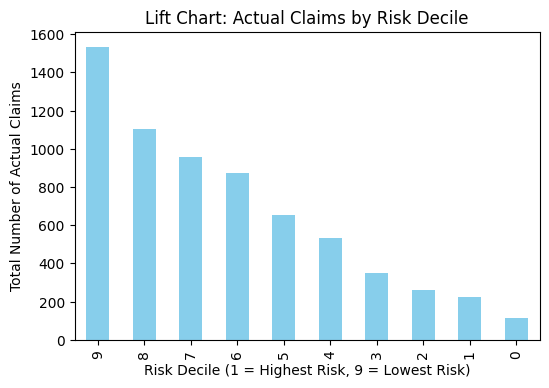

In [23]:
## Average predictions in actual target bins:
tmp = pd.DataFrame({'actual':y_train, 'predicted':y_train_pred})
print(tmp.groupby('actual')['predicted'].mean())

tmp2 = pd.DataFrame({'actual':y_test, 'predicted':y_test_pred})
print(tmp2.groupby('actual')['predicted'].mean())

## Lift Chart:
tmp2['decile'] = pd.qcut(tmp2['predicted'], 10, labels=False, duplicates='drop')

# Calculate the claim rate in each decile
decile_analysis = tmp2.groupby('decile')['actual'].sum().sort_index(ascending=False)

decile_analysis.plot(kind='bar', figsize=(6,4), color='skyblue')
plt.title('Lift Chart: Actual Claims by Risk Decile')
plt.xlabel('Risk Decile (1 = Highest Risk, 9 = Lowest Risk)')
plt.ylabel('Total Number of Actual Claims')
plt.show()

In [24]:
## Tree based models:

Training until validation scores don't improve for 50 rounds
[50]	train's poisson: 0.400764	valid's poisson: 0.402856
[100]	train's poisson: 0.394277	valid's poisson: 0.397497
[150]	train's poisson: 0.391918	valid's poisson: 0.396284
[200]	train's poisson: 0.390434	valid's poisson: 0.396007
[250]	train's poisson: 0.389162	valid's poisson: 0.395954
[300]	train's poisson: 0.387988	valid's poisson: 0.395847
[350]	train's poisson: 0.386877	valid's poisson: 0.395898
Early stopping, best iteration is:
[301]	train's poisson: 0.387967	valid's poisson: 0.395843

LightGBM Poisson Metrics:
  RMSE: 0.3834
  MAE: 0.2118

Baseline (ȳ × exposure) Metrics:
  RMSE: 0.3953
  MAE: 0.2485

--- Relative Improvement over Baseline ---
RMSE Improvement: 3.03%
MAE Improvement: 14.78%


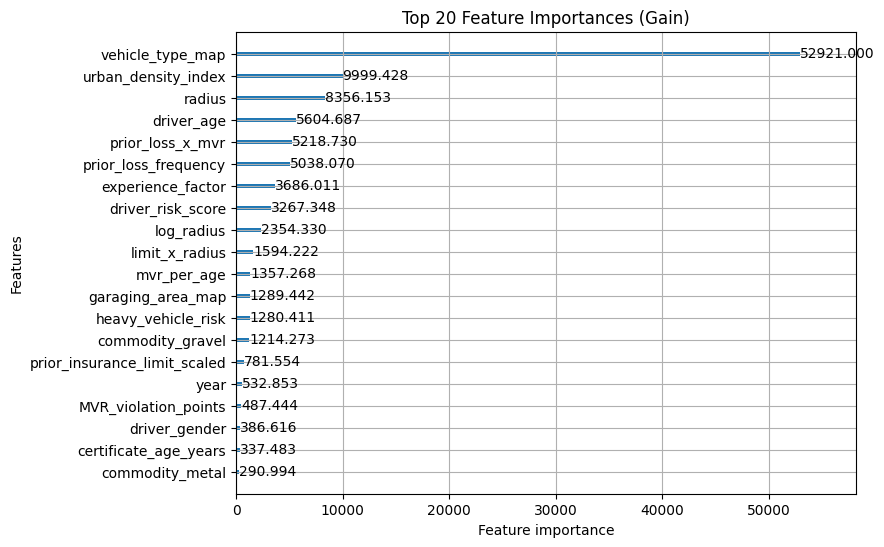

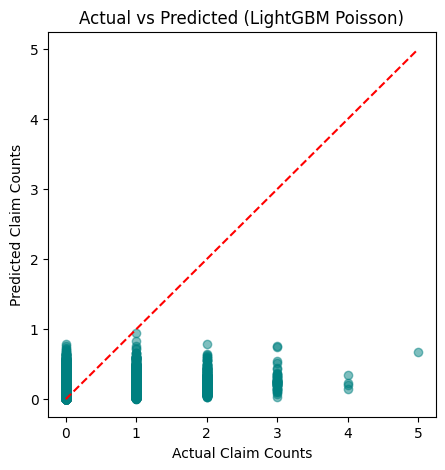

In [25]:
## Light GBM

# -------------------------------
# Step 1: Prepare Target & Exposure
# -------------------------------

# Target: Claim frequency
y = base['claim_counts']
exposure = base['insured_years']
y_freq = y / exposure   # claim frequency

# Feature selection (similar to your GLM)
exclude_cols = ['claim_counts', 'insured_years']
feature_cols = [c for c in base.columns if c not in exclude_cols]
X = base[feature_cols].copy()

# -------------------------------
# Step 2: Train-Test Split
# -------------------------------
X_train, X_test, y_train, y_test, exp_train, exp_test = train_test_split(
    X, y, exposure, test_size=0.2, random_state=42
)

# -------------------------------
# Step 3: Train LightGBM Poisson Model
# -------------------------------
# Prepare datasets
train_data = lgb.Dataset(X_train, label=y_train, weight=exp_train)
valid_data = lgb.Dataset(X_test, label=y_test, weight=exp_test, reference=train_data)

# Parameters
params = {
    'objective': 'poisson',
    'boosting_type': 'gbdt',
    'metric': 'poisson',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'seed': 42
}

# Train with early stopping using callbacks
lgb_model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, valid_data],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(50)]
)

# -------------------------------
# Step 4: Predictions
# -------------------------------
y_train_pred = lgb_model.predict(X_train)
y_test_pred = lgb_model.predict(X_test)

# Optional: convert predicted frequencies back to counts if needed
y_train_pred_count = y_train_pred * exp_train
y_test_pred_count = y_test_pred * exp_test

# -------------------------------
# Step 5: Baseline Model
# -------------------------------
y_mean_rate = (y_train / exp_train).mean()
y_baseline = y_mean_rate * exp_test

# -------------------------------
# Step 6: Evaluation Metrics
# -------------------------------
def evaluate_model(y_true, y_pred, label):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"\n{label} Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    return rmse, mae

rmse_model, mae_model = evaluate_model(y_test, y_test_pred_count, "LightGBM Poisson")
rmse_base, mae_base = evaluate_model(y_test, y_baseline, "Baseline (ȳ × exposure)")

# Relative Improvement
def rel_improve(base, model):
    return (base - model) / base * 100

print("\n--- Relative Improvement over Baseline ---")
print(f"RMSE Improvement: {rel_improve(rmse_base, rmse_model):.2f}%")
print(f"MAE Improvement: {rel_improve(mae_base, mae_model):.2f}%")

# -------------------------------
# Step 7: Feature Importance
# -------------------------------
import matplotlib.pyplot as plt

lgb.plot_importance(lgb_model, max_num_features=20, importance_type='gain', figsize=(8,6))
plt.title("Top 20 Feature Importances (Gain)")
plt.show()

# -------------------------------
# Step 8: Optional Plot
# -------------------------------
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_test_pred_count, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Claim Counts")
plt.ylabel("Predicted Claim Counts")
plt.title("Actual vs Predicted (LightGBM Poisson)")
plt.show()



Random Forest Metrics:
  RMSE: 0.3910
  MAE: 0.2413

Baseline (ȳ × exposure) Metrics:
  RMSE: 0.3953
  MAE: 0.2485

--- Relative Improvement over Baseline ---
RMSE Improvement: 1.09%
MAE Improvement: 2.87%


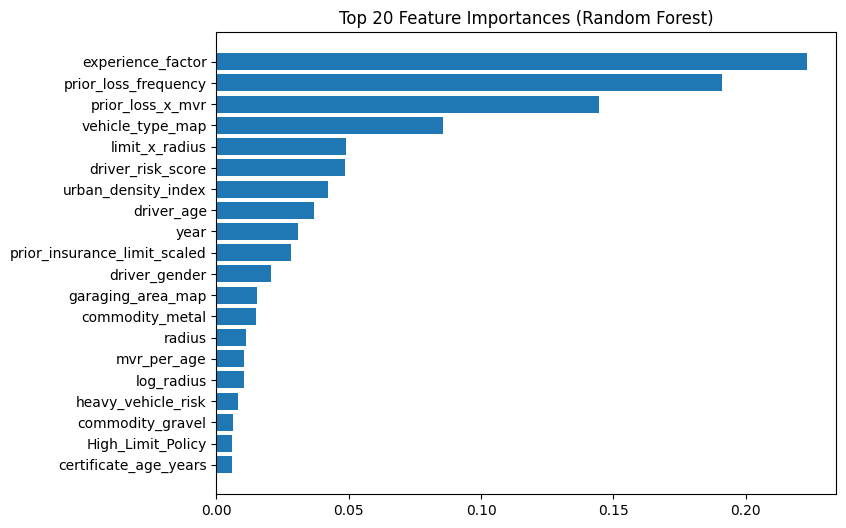

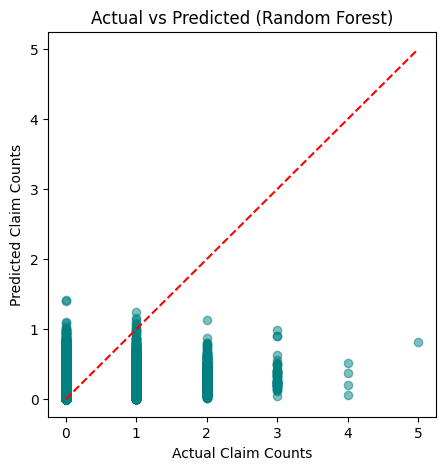

In [29]:
## RF:

# -------------------------------
# Step 1: Prepare Target & Exposure
# -------------------------------
y = base['claim_counts']
exposure = base['insured_years']
y_freq = y / exposure   # claim frequency

exclude_cols = ['claim_counts', 'insured_years']
feature_cols = [c for c in base.columns if c not in exclude_cols]
X = base[feature_cols].copy()

# -------------------------------
# Step 2: Train-Test Split
# -------------------------------
X_train, X_test, y_train, y_test, exp_train, exp_test = train_test_split(
    X, y, exposure, test_size=0.2, random_state=42
)

# -------------------------------
# Step 3: Random Forest Model
# -------------------------------
# Using sample_weight = exposure to account for varying exposures
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train, sample_weight=exp_train)

# -------------------------------
# Step 4: Predictions
# -------------------------------
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

# -------------------------------
# Step 5: Baseline Model
# -------------------------------
y_mean_rate = (y_train / exp_train).mean()
y_baseline = y_mean_rate * exp_test

# -------------------------------
# Step 6: Evaluation Metrics
# -------------------------------
def evaluate_model(y_true, y_pred, label):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"\n{label} Metrics:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE: {mae:.4f}")
    return rmse, mae

rmse_model, mae_model = evaluate_model(y_test, y_test_pred, "Random Forest")
rmse_base, mae_base = evaluate_model(y_test, y_baseline, "Baseline (ȳ × exposure)")

# Relative Improvement
def rel_improve(base, model):
    return (base - model) / base * 100

print("\n--- Relative Improvement over Baseline ---")
print(f"RMSE Improvement: {rel_improve(rmse_base, rmse_model):.2f}%")
print(f"MAE Improvement: {rel_improve(mae_base, mae_model):.2f}%")

# -------------------------------
# Step 7: Feature Importance
# -------------------------------
importances = rf_model.feature_importances_
feat_imp = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values('Importance', ascending=False)
plt.figure(figsize=(8,6))
plt.barh(feat_imp['Feature'][:20][::-1], feat_imp['Importance'][:20][::-1])
plt.title("Top 20 Feature Importances (Random Forest)")
plt.show()

# -------------------------------
# Step 8: Actual vs Predicted Plot
# -------------------------------
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_test_pred, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Claim Counts")
plt.ylabel("Predicted Claim Counts")
plt.title("Actual vs Predicted (Random Forest)")
plt.show()


[0]	train-poisson-nloglik:0.44341	valid-poisson-nloglik:0.44433
[50]	train-poisson-nloglik:0.41157	valid-poisson-nloglik:0.41413
[100]	train-poisson-nloglik:0.40534	valid-poisson-nloglik:0.40942
[150]	train-poisson-nloglik:0.40280	valid-poisson-nloglik:0.40840
[200]	train-poisson-nloglik:0.40118	valid-poisson-nloglik:0.40834
[244]	train-poisson-nloglik:0.39994	valid-poisson-nloglik:0.40837

XGBoost Poisson Metrics:
  RMSE: 0.3835
  MAE: 0.2368

Baseline (ȳ × exposure) Metrics:
  RMSE: 0.3953
  MAE: 0.2485

--- Relative Improvement over Baseline ---
RMSE Improvement: 3.01%
MAE Improvement: 4.69%


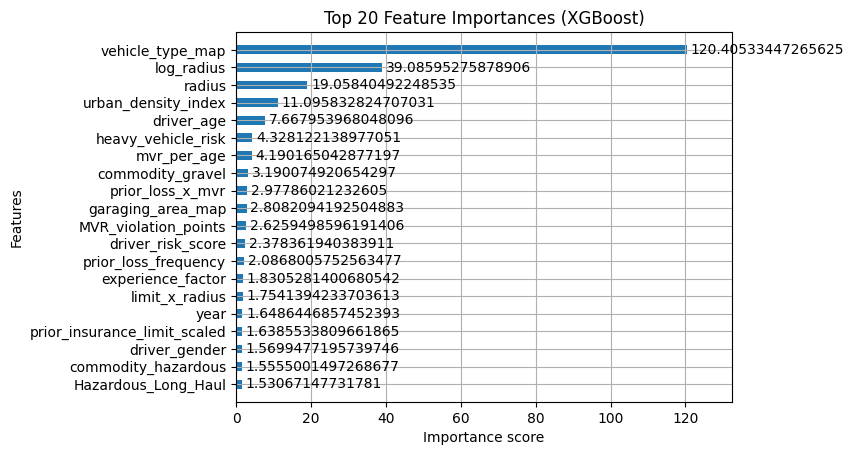

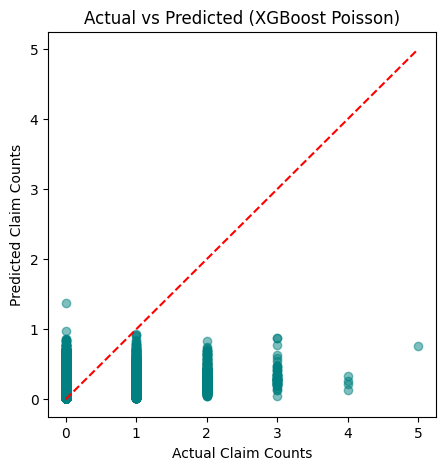

In [30]:
## XGB

# -------------------------------
# Step 1: Convert to DMatrix
# -------------------------------
dtrain = xgb.DMatrix(X_train, label=y_train, weight=exp_train)
dtest = xgb.DMatrix(X_test, label=y_test, weight=exp_test)

# -------------------------------
# Step 2: Parameters
# -------------------------------
params = {
    'objective': 'count:poisson',  # Poisson regression for counts
    'eval_metric': 'poisson-nloglik',
    'eta': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

evals = [(dtrain, 'train'), (dtest, 'valid')]

# -------------------------------
# Step 3: Train with early stopping
# -------------------------------
xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=50
)

# -------------------------------
# Step 4: Predictions
# -------------------------------
y_train_pred = xgb_model.predict(dtrain)
y_test_pred = xgb_model.predict(dtest)

# -------------------------------
# Step 5: Baseline Model
# -------------------------------
y_mean_rate = (y_train / exp_train).mean()
y_baseline = y_mean_rate * exp_test

# -------------------------------
# Step 6: Evaluation Metrics
# -------------------------------
rmse_model, mae_model = evaluate_model(y_test, y_test_pred, "XGBoost Poisson")
rmse_base, mae_base = evaluate_model(y_test, y_baseline, "Baseline (ȳ × exposure)")

print("\n--- Relative Improvement over Baseline ---")
print(f"RMSE Improvement: {rel_improve(rmse_base, rmse_model):.2f}%")
print(f"MAE Improvement: {rel_improve(mae_base, mae_model):.2f}%")

# -------------------------------
# Step 7: Feature Importance
# -------------------------------
xgb.plot_importance(xgb_model, max_num_features=20, importance_type='gain', height=0.5)
plt.title("Top 20 Feature Importances (XGBoost)")
plt.show()

# -------------------------------
# Step 8: Actual vs Predicted Plot
# -------------------------------
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_test_pred, alpha=0.5, color='teal')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Claim Counts")
plt.ylabel("Predicted Claim Counts")
plt.title("Actual vs Predicted (XGBoost Poisson)")
plt.show()


In [28]:
## Doing Feature Selection and Hyperparameter Tuning:

In [29]:
# Feature Selection:

# Using Random Forest as the base estimator for SFS
rf_base = RandomForestRegressor(
    n_estimators=100, 
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Using exposure as sample weights
sfs = SequentialFeatureSelector(
    rf_base,
    k_features=10,   # select top 10 features (adjust as needed)
    forward=True,
    floating=False,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)

sfs.fit(X_train, y_train, sample_weight=exp_train)
    
# Selected features
selected_features = list(sfs.k_feature_names_)
print("Selected Features via SFS:", selected_features)


Selected Features via SFS: ['radius', 'driver_age', 'MVR_violation_points', 'garaging_area_map', 'vehicle_type_map', 'commodity_gravel', 'commodity_metal', 'log_radius', 'urban_density_index', 'mvr_per_age']


In [30]:
# Using Random Forest as the base estimator for SFS
rf_base = RandomForestRegressor(
    n_estimators=100, 
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Using exposure as sample weights
sfs = SequentialFeatureSelector(
    rf_base,
    k_features=15,   # select top 10 features (adjust as needed)
    forward=True,
    floating=False,
    scoring='neg_mean_squared_error',
    cv=3,
    n_jobs=-1
)

sfs.fit(X_train, y_train, sample_weight=exp_train)
    
# Selected features
selected_features = list(sfs.k_feature_names_)
print("Selected Features via SFS:", selected_features)


Selected Features via SFS: ['radius', 'driver_age', 'MVR_violation_points', 'garaging_area_map', 'vehicle_type_map', 'commodity_gravel', 'commodity_hazardous', 'commodity_liquids - fuel', 'commodity_metal', 'High_Limit_Policy', 'Hazardous_Long_Haul', 'log_radius', 'heavy_vehicle_risk', 'urban_density_index', 'mvr_per_age']


In [31]:
## Model Fitting with hyper-parameter tuning:

In [32]:
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3, 5, 8, 10],
    'min_samples_split': [10, 20, 50],
    'min_samples_leaf': [10, 20, 50],
    'max_features': ['auto', 'sqrt']
}

rf_random = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

rf_random.fit(X_train[selected_features], y_train, sample_weight=exp_train)

print("Best Random Forest Params:", rf_random.best_params_)
best_rf_model = rf_random.best_estimator_

# Use the tuned models
models = {
    'Random Forest': best_rf_model
}

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test[selected_features])
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    poisson_dev = mean_poisson_deviance(y_test, y_pred)
    results[name] = (rmse, mae, poisson_dev)
    print(f"\n{name} Metrics after tuning:")
    print(f"  RMSE: {rmse:.4f}, MAE: {mae:.4f}, Poisson Deviance: {poisson_dev:.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Random Forest Params: {'n_estimators': 100, 'min_samples_split': 50, 'min_samples_leaf': 50, 'max_features': 'sqrt', 'max_depth': 10}

Random Forest Metrics after tuning:
  RMSE: 0.3836, MAE: 0.2389, Poisson Deviance: 0.5324


In [33]:
selected_features = ['radius', 'driver_age', 'MVR_violation_points', 'garaging_area_map', 'commodity_gravel', 'commodity_metal', 
                     'vehicle_type_map', 'urban_density_index', 'mvr_per_age']

rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

param_dist = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3, 5, 8, 10],
    'min_samples_split': [10, 20, 50],
    'min_samples_leaf': [10, 20, 50],
    'max_features': ['auto', 'sqrt']
}

rf_random = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

rf_random.fit(X_train[selected_features], y_train, sample_weight=exp_train)

print("Best Random Forest Params:", rf_random.best_params_)
best_rf_model = rf_random.best_estimator_

# Use the tuned models
models = {
    'Random Forest': best_rf_model
}

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test[selected_features])
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    poisson_dev = mean_poisson_deviance(y_test, y_pred)
    results[name] = (rmse, mae, poisson_dev)
    print(f"\n{name} Metrics after tuning:")
    print(f"  RMSE: {rmse:.4f}, MAE: {mae:.4f}, Poisson Deviance: {poisson_dev:.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Random Forest Params: {'n_estimators': 150, 'min_samples_split': 10, 'min_samples_leaf': 50, 'max_features': 'sqrt', 'max_depth': 8}

Random Forest Metrics after tuning:
  RMSE: 0.3835, MAE: 0.2381, Poisson Deviance: 0.5314


In [34]:
selected_features = ['radius', 'driver_age', 'MVR_violation_points', 'garaging_area_map', 'commodity_gravel', 'commodity_hazardous', 
                     'commodity_liquids - fuel', 'commodity_metal', 'vehicle_type_map', 'High_Limit_Policy', 'Hazardous_Long_Haul',  
                     'heavy_vehicle_risk', 'urban_density_index', 'mvr_per_age']


xgb_model = xgb.XGBRegressor(
    objective='count:poisson', 
    seed=42, 
    n_jobs=-1
)

param_dist_xgb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3, 5, 8, 10],
    'learning_rate': [0.001, 0.01, 0.05],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

xgb_random = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist_xgb,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

xgb_random.fit(X_train[selected_features], y_train, sample_weight=exp_train)

print("Best XGBoost Params:", xgb_random.best_params_)
best_xgb_model = xgb_random.best_estimator_

# Use the tuned models
models = {
    'XGB': best_xgb_model
}

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test[selected_features])
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    poisson_dev = mean_poisson_deviance(y_test, y_pred)
    results[name] = (rmse, mae, poisson_dev)
    print(f"\n{name} Metrics after tuning:")
    print(f"  RMSE: {rmse:.4f}, MAE: {mae:.4f}, Poisson Deviance: {poisson_dev:.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best XGBoost Params: {'subsample': 0.8, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1.0}

XGB Metrics after tuning:
  RMSE: 0.3833, MAE: 0.2376, Poisson Deviance: 0.5308


In [31]:
selected_features = ['radius', 'driver_age', 'MVR_violation_points', 'garaging_area_map', 'commodity_gravel', 'commodity_metal', 
                     'vehicle_type_map', 'urban_density_index', 'mvr_per_age']


xgb_model = xgb.XGBRegressor(
    objective='count:poisson', 
    seed=42, 
    n_jobs=-1
)

param_dist_xgb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3, 5, 8, 10],
    'learning_rate': [0.001, 0.01, 0.05],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

xgb_random = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist_xgb,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

xgb_random.fit(X_train[selected_features], y_train, sample_weight=exp_train)

print("Best XGBoost Params:", xgb_random.best_params_)
best_xgb_model = xgb_random.best_estimator_

# Use the tuned models
models = {
    'XGB': best_xgb_model
}

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test[selected_features])
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    poisson_dev = mean_poisson_deviance(y_test, y_pred)
    results[name] = (rmse, mae, poisson_dev)
    print(f"\n{name} Metrics after tuning:")
    print(f"  RMSE: {rmse:.4f}, MAE: {mae:.4f}, Poisson Deviance: {poisson_dev:.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best XGBoost Params: {'subsample': 0.8, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.05, 'colsample_bytree': 1.0}

XGB Metrics after tuning:
  RMSE: 0.3833, MAE: 0.2376, Poisson Deviance: 0.5308


In [36]:
selected_features = ['radius', 'driver_age', 'MVR_violation_points', 'garaging_area_map', 'commodity_gravel', 'commodity_hazardous', 
                     'commodity_liquids - fuel', 'commodity_metal', 'vehicle_type_map', 'High_Limit_Policy', 'Hazardous_Long_Haul',  
                     'heavy_vehicle_risk', 'urban_density_index', 'mvr_per_age']

lgb_model = lgb.LGBMRegressor(
    objective='poisson',
    random_state=42,
    n_jobs=-1
)

param_dist_lgb = {
    'num_leaves': [20, 30, 50],
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3, 5, 8, 10],
    'learning_rate': [0.001, 0.01, 0.05],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'min_child_samples': [10, 20, 50]
}

lgb_random = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist_lgb,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

lgb_random.fit(X_train[selected_features], y_train, sample_weight=exp_train)

print("Best LightGBM Params:", lgb_random.best_params_)
best_lgb_model = lgb_random.best_estimator_

# Use the tuned models
models = {
    'Light GBM': best_lgb_model
}

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test[selected_features])
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    poisson_dev = mean_poisson_deviance(y_test, y_pred)
    results[name] = (rmse, mae, poisson_dev)
    print(f"\n{name} Metrics after tuning:")
    print(f"  RMSE: {rmse:.4f}, MAE: {mae:.4f}, Poisson Deviance: {poisson_dev:.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best LightGBM Params: {'subsample': 1.0, 'num_leaves': 30, 'n_estimators': 150, 'min_child_samples': 50, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 0.7}

Light GBM Metrics after tuning:
  RMSE: 0.3834, MAE: 0.2381, Poisson Deviance: 0.5314


In [37]:
selected_features = ['radius', 'driver_age', 'MVR_violation_points', 'garaging_area_map', 'commodity_gravel', 'commodity_metal', 
                     'vehicle_type_map', 'urban_density_index', 'mvr_per_age']

lgb_model = lgb.LGBMRegressor(
    objective='poisson',
    random_state=42,
    n_jobs=-1
)

param_dist_lgb = {
    'num_leaves': [20, 30, 50],
    'n_estimators': [50, 100, 150],
    'max_depth': [2, 3, 5, 8, 10],
    'learning_rate': [0.001, 0.01, 0.05],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'min_child_samples': [10, 20, 50]
}

lgb_random = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist_lgb,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

lgb_random.fit(X_train[selected_features], y_train, sample_weight=exp_train)

print("Best LightGBM Params:", lgb_random.best_params_)
best_lgb_model = lgb_random.best_estimator_

# Use the tuned models
models = {
    'Light GBM': best_lgb_model
}

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test[selected_features])
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    poisson_dev = mean_poisson_deviance(y_test, y_pred)
    results[name] = (rmse, mae, poisson_dev)
    print(f"\n{name} Metrics after tuning:")
    print(f"  RMSE: {rmse:.4f}, MAE: {mae:.4f}, Poisson Deviance: {poisson_dev:.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best LightGBM Params: {'subsample': 1.0, 'num_leaves': 30, 'n_estimators': 150, 'min_child_samples': 50, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 0.7}

Light GBM Metrics after tuning:
  RMSE: 0.3833, MAE: 0.2382, Poisson Deviance: 0.5314


In [38]:
# Use the tuned models
models = {
    'Random Forest': best_rf_model,
    'XGBoost Poisson': best_xgb_model,
    'LightGBM Poisson': best_lgb_model
}

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test[selected_features])
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    poisson_dev = mean_poisson_deviance(y_test, y_pred)
    results[name] = (rmse, mae, poisson_dev)
    print(f"\n{name} Metrics after tuning:")
    print(f"  RMSE: {rmse:.4f}, MAE: {mae:.4f}, Poisson Deviance: {poisson_dev:.4f}")



Random Forest Metrics after tuning:
  RMSE: 0.3835, MAE: 0.2381, Poisson Deviance: 0.5314

XGBoost Poisson Metrics after tuning:
  RMSE: 0.3833, MAE: 0.2376, Poisson Deviance: 0.5308

LightGBM Poisson Metrics after tuning:
  RMSE: 0.3833, MAE: 0.2382, Poisson Deviance: 0.5314


In [39]:
## FINAL MODEL:

In [32]:
# Use the tuned models
models = {
    # 'Random Forest': best_rf_model,
    'XGBoost Poisson': best_xgb_model,
    # 'LightGBM Poisson': best_lgb_model
}

results = {}

for name, model in models.items():
    y_pred = model.predict(X_test[selected_features])
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    poisson_dev = mean_poisson_deviance(y_test, y_pred)
    results[name] = (rmse, mae, poisson_dev)
    print(f"\n{name} Metrics after tuning:")
    print(f"  RMSE: {rmse:.4f}, MAE: {mae:.4f}, Poisson Deviance: {poisson_dev:.4f}")



XGBoost Poisson Metrics after tuning:
  RMSE: 0.3833, MAE: 0.2376, Poisson Deviance: 0.5308


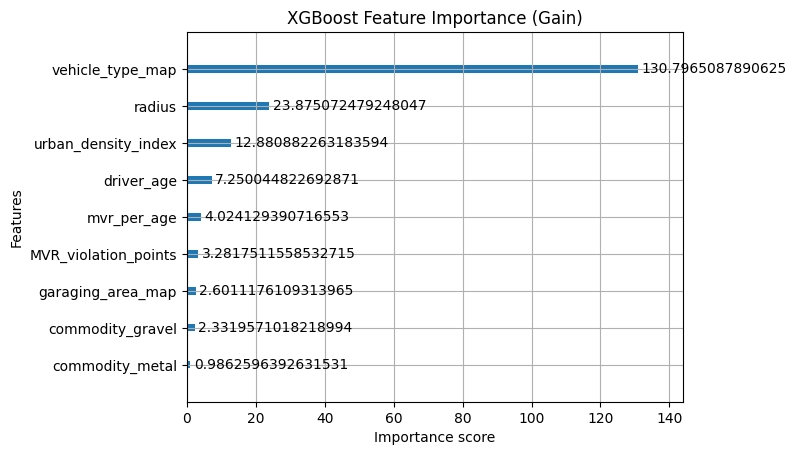

In [33]:
xgb.plot_importance(model, importance_type='gain', max_num_features=15)
plt.title("XGBoost Feature Importance (Gain)")
plt.show()

In [34]:
import pickle

# Define the filename for your saved model
filename = 'xgboost_claim_model.pkl'

# Open the file in binary write mode ('wb') and save the model
with open(filename, 'wb') as file:
    pickle.dump(model, file)

print(f"Model saved successfully to {filename}")

Model saved successfully to xgboost_claim_model.pkl


In [35]:
# Generate predictions on the entire 'base' dataset
predictions = model.predict(base[selected_features])

# Add the predictions as a new column
base['predicted_claim_count'] = predictions

# Save the final dataframe to a new CSV file
output_filename = 'predictions_with_base_data.csv'
base.to_csv(output_filename, index=False)

print(f"Successfully preprocessed data, added predictions, and saved the combined data to '{output_filename}'")

Successfully preprocessed data, added predictions, and saved the combined data to 'predictions_with_base_data.csv'


In [41]:
tmp = pd.DataFrame({'actual':y_train, 'predicted':y_train_pred})
tmp.groupby('actual')['predicted'].mean()

actual
0    0.137555
1    0.218760
2    0.295115
3    0.385361
4    0.620779
Name: predicted, dtype: float32

In [42]:
tmp2 = pd.DataFrame({'actual':y_test, 'predicted':y_test_pred})
tmp2.groupby('actual')['predicted'].mean()

actual
0    0.138974
1    0.210611
2    0.269594
3    0.336538
4    0.234364
5    0.763772
Name: predicted, dtype: float32

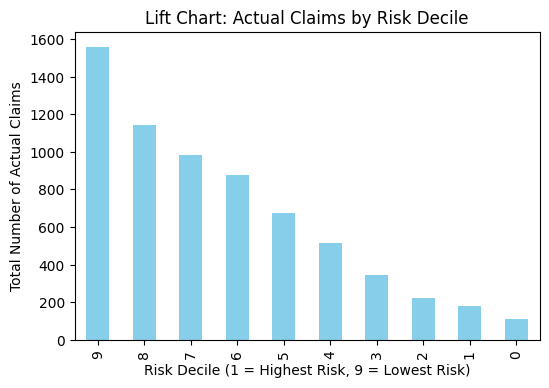

In [43]:
tmp2['decile'] = pd.qcut(tmp2['predicted'], 10, labels=False, duplicates='drop')

# Calculate the claim rate in each decile
decile_analysis = tmp2.groupby('decile')['actual'].sum().sort_index(ascending=False)

decile_analysis.plot(kind='bar', figsize=(6, 4), color='skyblue')
plt.title('Lift Chart: Actual Claims by Risk Decile')
plt.xlabel('Risk Decile (1 = Highest Risk, 9 = Lowest Risk)')
plt.ylabel('Total Number of Actual Claims')
plt.show()

In [44]:
# --- Baseline Model Comparison ---
print("\n--- Baseline Model (y = mean of training set) ---")

# Baseline prediction: constant mean of training y
y_baseline = np.full_like(y_test, y_train.mean(), dtype=float)

# Baseline metrics
rmse_base = np.sqrt(mean_squared_error(y_test, y_baseline))
mae_base = mean_absolute_error(y_test, y_baseline)
poisson_dev_base = mean_poisson_deviance(y_test, y_baseline)

print(f"Baseline RMSE: {rmse_base:.4f}")
print(f"Baseline MAE: {mae_base:.4f}")
print(f"Baseline Poisson Deviance: {poisson_dev_base:.4f}")

# --- Relative Improvement (% decrease from baseline) ---
def rel_improvement(base, model):
    return ((base - model) / base) * 100

print("\n--- Relative Improvement vs Baseline ---")
print(f"RMSE Improvement: {rel_improvement(rmse_base, rmse):.2f}%")
print(f"MAE Improvement: {rel_improvement(mae_base, mae):.2f}%")
print(f"Poisson Deviance Improvement: {rel_improvement(poisson_dev_base, poisson_dev):.2f}%")



--- Baseline Model (y = mean of training set) ---
Baseline RMSE: 0.3965
Baseline MAE: 0.2501
Baseline Poisson Deviance: 0.6019

--- Relative Improvement vs Baseline ---
RMSE Improvement: 3.32%
MAE Improvement: 5.01%
Poisson Deviance Improvement: 11.82%
